In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# parameters
volume_shape = (32, 32, 32)
num_samples = 200
nodules_perc = 0.5

In [3]:
def generate_synthetic_ct_data(n_samples, volume_shape, nodule_ratio=0.5):
    X = np.zeros((n_samples, *volume_shape, 1), dtype=np.float32)
    y = np.zeros(n_samples)

    for i in range(n_samples):
        volume = np.random.normal(loc=0.2, scale=0.1, size=(*volume_shape, 1)).astype(np.float32)

        if i < int(n_samples * nodule_ratio):
            center = np.random.randint(8, 24, size=3)
            radius = np.random.randint(3, 6)
            zz, yy, xx = np.ogrid[:volume_shape[0], :volume_shape[1], :volume_shape[2]]
            dist = np.sqrt((xx - center[0])**2 + (yy - center[1])**2 + (zz - center[2])**2)
            mask = dist <= radius
            volume[mask, 0] = np.random.normal(loc=0.8, scale=0.1, size=mask.sum())
            y[i] = 1

        X[i] = volume
    return X, y

In [4]:
X, y = generate_synthetic_ct_data(num_samples, volume_shape, nodules_perc)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (160, 32, 32, 32, 1) (160,)
Validation set: (40, 32, 32, 32, 1) (40,)


# 3D CNN Model

In [5]:
def build_3d_cnn(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv3D(32, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=2),

        layers.Conv3D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=2),

        layers.Conv3D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=2),

        layers.GlobalAveragePooling3D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model

In [6]:
# build the model
model = build_3d_cnn((*volume_shape, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 8, 8, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,209 (1.12 MB)

 Trainable params: 294,209 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [7]:
# early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5546 - auc: 0.4888 - loss: 0.7085 - val_accuracy: 0.5000 - val_auc: 0.9250 - val_loss: 0.6923
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4558 - auc: 0.4428 - loss: 0.7009 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6926
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5366 - auc: 0.5457 - loss: 0.6909 - val_accuracy: 0.5000 - val_auc: 1.0000 - val_loss: 0.6928
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4985 - auc: 0.4978 - loss: 0.6928 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6923
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5307 - auc: 0.5361 - loss: 0.6934 - val_accuracy: 0.8000 - val_auc: 0.5000 - val_loss: 0.6914
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4937 - auc: 0.4769 - loss: 0.6929 - val_accuracy: 1.0000 - val_auc: 0.8750 - val_loss: 0.6889
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

# Plot Accuracy and Loss

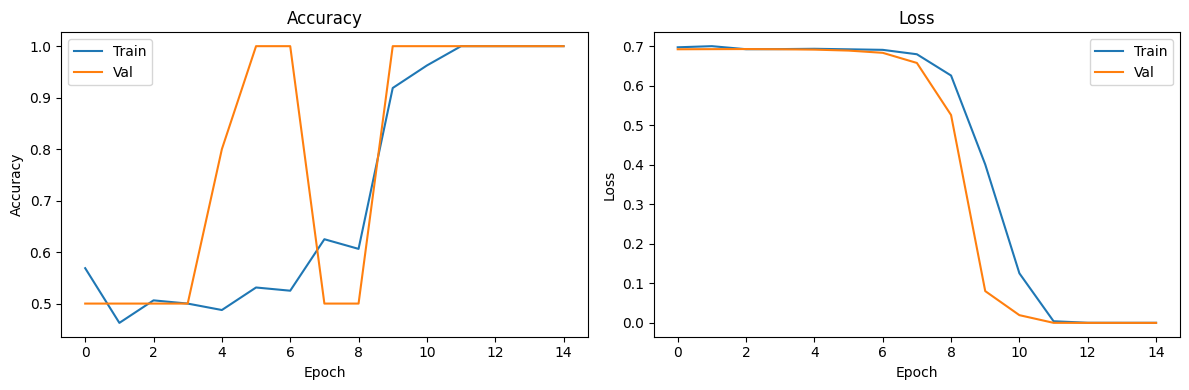

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize Predictions with CT Slices

In [9]:
def show_volume_slices(volume, title, n_slices=4):
    idxs = np.linspace(0, volume.shape[0]-1, n_slices).astype(int)
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n_slices, i+1)
        plt.imshow(volume[idx, :, :, 0], cmap='gray')
        plt.title(f"Slice {idx}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# predict on validation
pred_probs = model.predict(X_val).flatten()
pred_labels = (pred_probs > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


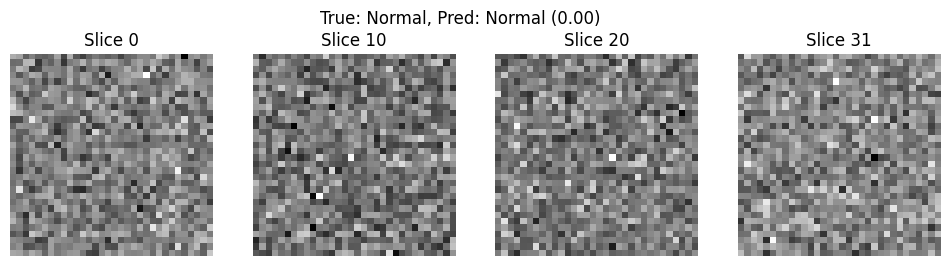

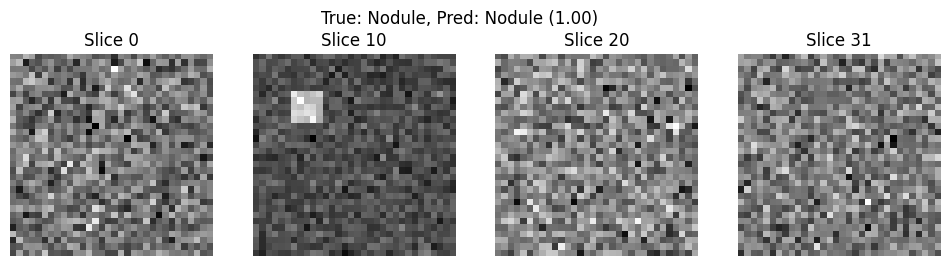

In [10]:
for label in [0, 1]:
    idx = np.where(y_val == label)[0][0]
    title = f"True: {'Nodule' if y_val[idx]==1 else 'Normal'}, Pred: {'Nodule' if pred_labels[idx]==1 else 'Normal'} ({pred_probs[idx]:.2f})"
    show_volume_slices(X_val[idx], title)

# Evaluation Metrics and Confusion Matrix

In [11]:
print("Classification Report:")
print(classification_report(y_val, pred_labels, target_names=["Normal", "Nodule"]))

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        20
      Nodule       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



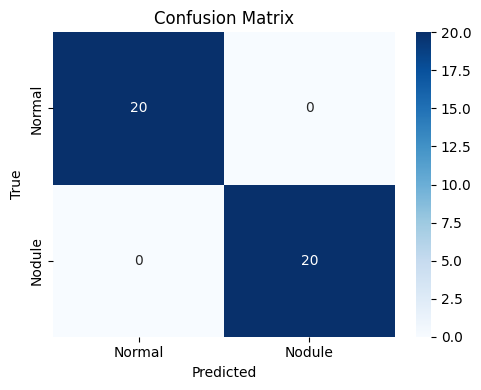

In [12]:
cm = confusion_matrix(y_val, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Nodule"], yticklabels=["Normal", "Nodule"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Save the Model

In [13]:
model.save("3d_ct_nodule_classifier.keras")
print("model saved as '3d_ct_nodule_classifier.keras'")

model saved as '3d_ct_nodule_classifier.keras'
